# Figure 6

Load librairies

In [1]:
import numpy as np                  # Data
import pandas as pd                 # Data
import matplotlib.pyplot as plt     # Plot
import matplotlib as mpl            # Plot

Use Latex font

In [2]:
plt.rcParams.update({'text.usetex': True,
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'font.size': 11,
                     'axes.labelsize': 11,
                     'legend.fontsize': 11,
                     'xtick.labelsize': 9,
                     'ytick.labelsize': 9})  

## Data & Methods

Read capacity factor verification data from 2014 to 2023

In [3]:
df_cf = pd.read_csv('../Data/cf_verification_2014-2023.csv',
                    index_col = 0,
                    parse_dates = True,
                    usecols = ['datetime', 'Solar OBS', 'Solar ATL', 'Solar C3S GRD', 'Solar C3S NAT']).dropna()

Select only 2023 data for solar PV

In [4]:
df_cf = df_cf.loc['2023']

Create function to calculate skill scores comparing the three models to the observations

In [5]:
def calculate_metrics(reference, model):
    cc = np.corrcoef(reference, model)[0, 1]
    rmse = np.sqrt(np.mean((reference - model) ** 2))
    mbe = np.mean(model - reference)
    return np.round(cc, 3), np.round(rmse,3),  np.round(mbe,3)

Apply the function and store the results in a pandas DataFrame

In [6]:
metrics = {}
reference = df_cf['Solar OBS']
models = ['Solar ATL', 'Solar C3S GRD', 'Solar C3S NAT']

for model in models:
    metrics[model] = calculate_metrics(reference, df_cf[model])

df_metrics = pd.DataFrame(metrics, index=['CC', 'RMSE', 'MBE'])

## Plot

Create custom colormap

In [ ]:
def truncate_colormap(cmap, minval = 0.0, maxval = 1.0, n = 100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n = cmap.name, a = minval, b = maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = truncate_colormap(mpl.colormaps['viridis'], maxval = 0.2, minval = 0.95)
cmap = cmap.resampled(6)

bounds = [1, 5, 10, 50, 100, 500]

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [9]:
bins = np.arange(-0.025, 1.05, 0.05)
centered_bins = 0.5 * (bins[1:] + bins[:-1])

models = {'ATL': df_cf['Solar ATL'].values,
          'C3S GRD': df_cf['Solar C3S GRD'].values,
          'C3S NAT': df_cf['Solar C3S NAT'].values}

cm = 1 / 2.54

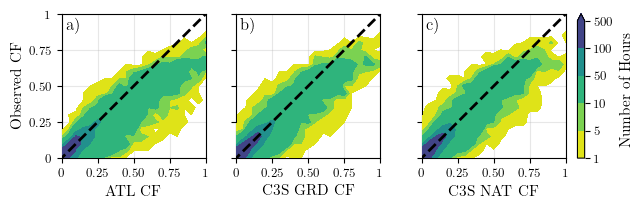

In [10]:
fig, ax = plt.subplots(1, 3, 
                       figsize=(16*cm, 5*cm),
                       constrained_layout=True)

for i, (label, model_data) in enumerate(models.items()):
    # Create histogram
    hist, _, _ = np.histogram2d(x = model_data, y = df_cf['Solar OBS'].values,
                                bins = bins,
                                density = False)
    
    # Contour plot
    im = ax[i].contourf(centered_bins, centered_bins,
                        hist.T,
                        levels = bounds,
                        cmap = cmap,
                        norm = norm,
                        extend = 'max',
                        zorder = 3)
    
    # Add diagonal line
    ax[i].plot(bins, bins,
               c = 'k',
               lw = 2,
               ls = '--',
               zorder = 5)
    
    # Axis properties
    ax[i].set_aspect(1.)

    ax[i].set_xlim(0, 1)
    ax[i].set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax[i].set_xticklabels(['0', '0.25', '0.50', '0.75', '1'])
    ax[i].set_xlabel(f'{label} CF')

    ax[i].set_ylim(0, 1)
    ax[i].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[i].set_yticklabels(['0', '0.25', '0.50', '0.75', '1'])
    if i != 0:
        ax[i].set_yticklabels([])
    else:
        ax[i].set_ylabel('Observed CF')

    ax[i].grid(True, alpha = 0.3, zorder = 0)

    ax[i].text(0.03, 0.98,
               f'{chr(97 + i)})',
               fontsize = 12,
               ha = 'left', va = 'top',
               transform = ax[i].transAxes)

cbar = fig.colorbar(im, ax = ax[-1])
cbar.set_label('Number of Hours')

# plt.savefig('06_verification_pv_contour.png', bbox_inches='tight', dpi=300)